In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm 
import numpy as np
import pandas as pd 
from glob import glob
import subprocess
import gc 
import shutil
import random

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Old ImageNet code

In [49]:
checkpoint_prefix = "runwayml_imagenet_"
best_checkpoints = {"class94_hummingbird": "1000", 
               "class94_bird-feeder": "500", 
               "class94_flower": "500", 
               "class94_branch": "2000", }

In [50]:
path_to_classes = {}
for checkpoint_name, checkpoint_num in best_checkpoints.items(): 
    path_to_classes[checkpoint_name] = f"imagenet_runwayml_dreambooth_imgs/{checkpoint_prefix}{checkpoint_name}/checkpoint-{checkpoint_num}-preprocessed"

In [51]:
path_to_classes

{'class94_hummingbird': 'imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_hummingbird/checkpoint-1000-preprocessed',
 'class94_bird-feeder': 'imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_bird-feeder/checkpoint-500-preprocessed',
 'class94_flower': 'imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-500-preprocessed',
 'class94_branch': 'imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_branch/checkpoint-2000-preprocessed'}

In [86]:
class MaskedImageNet(Dataset): 
    def __init__(self, path_to_classes, split='train', data_transforms=None): 
        self.split = split
        self.path_to_classes = path_to_classes
        self.class_names = list(sorted(path_to_classes.keys()))
        self.samples = self.make_dataset()
        if data_transforms: 
            self.transforms = data_transforms 
        else: 
            self.transforms = transforms.ToTensor()

    def __len__(self): 
        return len(self.samples)

    def __getitem__(self, idx): 
        img_path, label = self.samples[idx] 
        img = Image.open(img_path)
        
        if self.transforms: 
            img = self.transforms(img)
            
        return img, label

    def make_dataset(self): 
        self.class_to_label = {x: i for i, x in enumerate(self.class_names)}
        self.label_to_class = {v: k for k, v in self.class_to_label.items()}
        samples = []
        for class_name, class_path in self.path_to_classes.items(): 
            img_paths = glob(class_path + "/*.png", recursive=True)
            label = self.class_to_label[class_name]
            samples += [(x, label) for x in img_paths]
        return samples 

In [87]:
# Images are 512x512 

train_transforms = transforms.Compose([
                                 transforms.RandomRotation(30),
                                 transforms.RandomHorizontalFlip(p=0.5), 
                                 transforms.ToTensor(), 
                                 # Use standard ImageNet normalization 
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])
test_transforms = transforms.Compose([
                                 transforms.ToTensor(), 
                                 # Use standard ImageNet normalization 
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

In [88]:
train_dataset = MaskedImageNet(path_to_classes, data_transforms=train_transforms)

In [89]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

torch.Size([1, 3, 512, 512])
tensor([-1.0659, -1.9757, -1.5061])
tensor(-2.1179)
tensor(2.2489)
tensor([1])


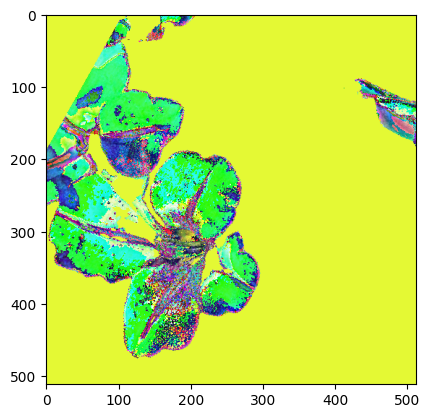

In [43]:
for img, label in train_dataloader: 
    print(img.size()) 
    print(torch.mean(img, dim=[0, 2, 3]))
    print(torch.min(img))
    print(torch.max(img))
    print(label)
    plt.imshow(transforms.functional.to_pil_image(img[0, :, :, :]))
    break

In [47]:
# Dataloader for actual training
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [45]:
# Custom encoder 
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /data/healthy-ml/scratch/qixuanj/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


In [46]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [54]:
len(train_dataset.class_names)

4

In [55]:
# Set custom linear head 
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, len(train_dataset.class_names))
)

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
# If we wish to freeze ResNet50 parameters 

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [61]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [73]:
# ! pip install torcheval

In [75]:
from torcheval.metrics import MulticlassAUROC
from torcheval.metrics.classification import  MulticlassPrecision, MulticlassRecall

In [79]:
num_epochs = 20

metrics = {
    'loss': [], 'accuracy': [], 'auroc': [], 'precision': [], 'recall': [], 
}

for epoch in range(num_epochs): 
    ep_metrics = {
    'loss': 0, 'accuracy': 0, 'auroc': 0, 'precision': 0, 'recall': 0, 'count': 0,
    }
    print(f'Epoch {epoch}')
    
    for images, labels in train_dataloader: 
        optimizer.zero_grad()
    
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=len(train_dataset.class_names))
        loss = criterion(output, ohe_label.float().to(device))
        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)
        
        recall_m = MulticlassRecall(num_classes=len(train_dataset.class_names))
        recall_m.update(output, labels)
        recall = recall_m.compute()
        
        precision_m = MulticlassPrecision(num_classes=len(train_dataset.class_names))
        precision_m.update(output, labels)
        precision = precision_m.compute()
        
        auroc_m = MulticlassAUROC(num_classes=len(train_dataset.class_names)) 
        auroc_m.update(output, labels) 
        auroc = auroc_m.compute()
    
        # Backprop
        loss.backward()
        optimizer.step()
        ep_metrics['loss'] += loss.item()
        ep_metrics['accuracy'] += accuracy.item()
        ep_metrics['recall'] += recall.item()
        ep_metrics['precision'] += precision.item()
        ep_metrics['auroc'] += auroc.item()
        ep_metrics['count'] += 1
    ep_loss = ep_metrics['loss']/ep_metrics['count']
    ep_accuracy = ep_metrics['accuracy']/ep_metrics['count']
    ep_recall = ep_metrics['recall']/ep_metrics['count']
    ep_precision = ep_metrics['precision']/ep_metrics['count']
    ep_auroc = ep_metrics['auroc']/ep_metrics['count']
    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}, AUROC: {ep_auroc}, Recall: {ep_recall}, Precision: {ep_precision}\n')

    metrics['loss'].append(ep_loss)
    metrics['accuracy'].append(ep_accuracy)
    metrics['recall'].append(ep_recall)
    metrics['precision'].append(ep_precision)
    metrics['auroc'].append(ep_auroc) 

Epoch 0
Loss: 1.189265828728676, Accuracy: 0.545, AUROC: 0.5, Recall: 0.545, Precision: 0.545

Epoch 1
Loss: 1.1611462846398353, Accuracy: 0.575, AUROC: 0.5, Recall: 0.575, Precision: 0.575

Epoch 2
Loss: 1.1356151631474496, Accuracy: 0.585, AUROC: 0.5, Recall: 0.585, Precision: 0.585

Epoch 3
Loss: 1.1161942294239997, Accuracy: 0.65, AUROC: 0.5, Recall: 0.65, Precision: 0.65

Epoch 4
Loss: 1.0925442901253701, Accuracy: 0.605, AUROC: 0.5, Recall: 0.605, Precision: 0.605

Epoch 5
Loss: 1.0740039120614528, Accuracy: 0.625, AUROC: 0.5, Recall: 0.625, Precision: 0.625

Epoch 6
Loss: 1.0471053132414818, Accuracy: 0.64, AUROC: 0.5, Recall: 0.64, Precision: 0.64

Epoch 7
Loss: 1.0312153282761574, Accuracy: 0.685, AUROC: 0.5, Recall: 0.685, Precision: 0.685

Epoch 8
Loss: 1.0131721609830857, Accuracy: 0.645, AUROC: 0.5, Recall: 0.645, Precision: 0.645

Epoch 9
Loss: 1.0049773809313773, Accuracy: 0.665, AUROC: 0.5, Recall: 0.665, Precision: 0.665

Epoch 10
Loss: 0.9840175896883011, Accuracy: 0.

In [ ]:
# Softmax to prevent negative valeus 

In [92]:
output

tensor([[-0.1767,  0.8764, -0.1349, -1.1166]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [85]:
train_dataset.class_to_label

{'class94_bird-feeder': 0,
 'class94_branch': 1,
 'class94_flower': 2,
 'class94_hummingbird': 3}

Actual label: class94_hummingbird
Predicted label: class94_hummingbird


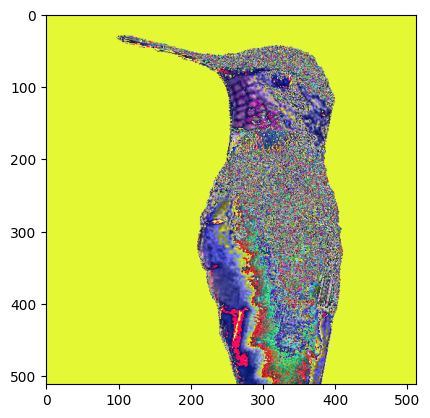

In [103]:
for images, labels in train_dataloader: 
    print("Actual label: {}".format(train_dataset.label_to_class[labels.item()]))
    with torch.no_grad(): 
        output = model(images.to(device))
        preds = torch.argmax(output, dim=1).item()
        print("Predicted label: {}".format(train_dataset.label_to_class[preds]))
    plt.imshow(transforms.functional.to_pil_image(images.squeeze()))
    plt.show()
    break